In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import geopy.distance
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from tqdm import tqdm

from hyperopt import hp, tpe, Trials
from hyperopt.fmin import fmin

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submission_df = pd.read_csv('sample_submission.csv')

In [4]:
data = train_df.dropna().drop(['tripid'],axis=1)
data.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
1,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
2,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
3,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
5,10.5,3407.0,182.0,0.0000,112.0,11/1/2019 5:38,11/1/2019 6:35,7.13402,79.8969,6.91865,79.8649,1065.02,correct


In [5]:
data = data[data['drop_lat'] < 30]

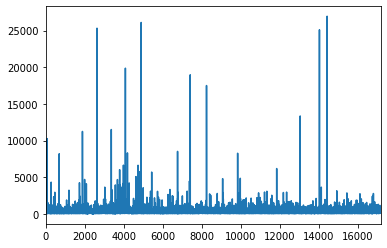

In [6]:
data['fare'].plot()

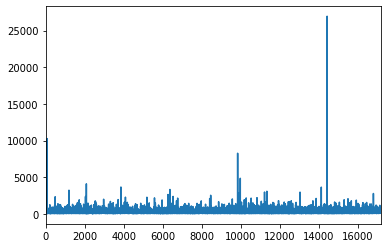

In [7]:
data[data['label']=='correct']['fare'].plot()

In [8]:
data[data['label']=='correct']['fare'].describe()

count    15441.000000
mean       277.625584
std        341.301572
min          0.000000
25%        125.060000
50%        204.720000
75%        341.580000
max      26945.990000
Name: fare, dtype: float64

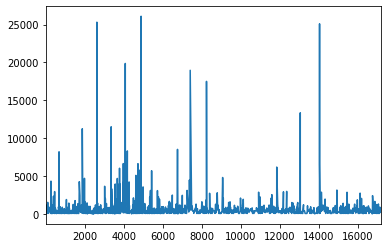

In [9]:
data[data['label']=='incorrect']['fare'].plot()

In [10]:
data[data['label']=='incorrect']['fare'].describe()

count     1526.000000
mean       667.299417
std       1665.277732
min          0.000000
25%        135.757500
50%        388.470000
75%        652.855000
max      26098.750000
Name: fare, dtype: float64

In [11]:
def calculate_trip_distance(row):
    coords_1 = (row['pick_lat'],row['pick_lon'])
    coords_2 = (row['drop_lat'],row['drop_lon'])
    return geopy.distance.geodesic(coords_1, coords_2).km

In [12]:
data['distance_km'] = data.apply(calculate_trip_distance,axis=1).clip(0,100)
test_df['distance_km'] = test_df.apply(calculate_trip_distance,axis=1).clip(0,100)

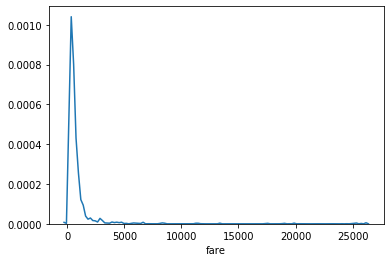

In [13]:
sns.distplot(data[data['label']=='incorrect']['fare'], hist=False)

In [14]:
data['distance_km'] = data.apply(calculate_trip_distance,axis=1).clip(0,100)
test_df['distance_km'] = test_df.apply(calculate_trip_distance,axis=1).clip(0,100)

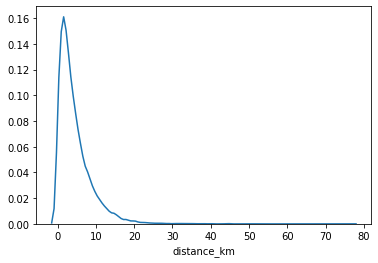

In [15]:
sns.distplot(data[data['label']=='correct']['distance_km'], hist=False)

In [16]:
data[data['label']=='correct']['distance_km'].describe()

count    15441.000000
mean         4.489414
std          4.455809
min          0.000000
25%          1.523517
50%          3.218233
75%          6.076375
max         76.392761
Name: distance_km, dtype: float64

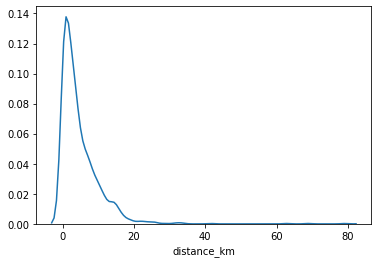

In [17]:
sns.distplot(data[data['label']=='incorrect']['distance_km'], hist=False)

In [18]:
data[data['label']=='incorrect']['distance_km'].describe()

count    1526.000000
mean        4.743636
std         5.758985
min         0.000000
25%         1.084613
50%         3.081331
75%         6.793153
max        79.217290
Name: distance_km, dtype: float64

In [19]:
data['fare_per_km'] = data['fare'] / (data['distance_km']+0.001)

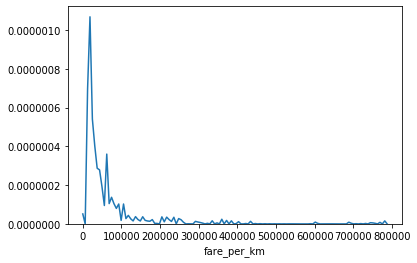

In [20]:
sns.distplot(data[data['label']=='correct']['fare_per_km'], hist=False)

In [21]:
data[data['label']=='correct']['fare_per_km'].describe()

count     15441.000000
mean       2258.348958
std       19271.289778
min           0.000000
25%          48.032535
50%          57.817121
75%          81.051559
max      787483.908219
Name: fare_per_km, dtype: float64

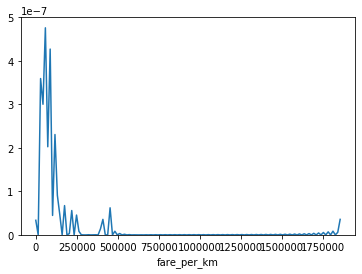

In [22]:
sns.distplot(data[data['label']=='incorrect']['fare_per_km'], hist=False)

In [23]:
data[data['label']=='incorrect']['fare_per_km'].describe()

count    1.526000e+03
mean     5.271268e+03
std      5.254241e+04
min      0.000000e+00
25%      5.232396e+01
50%      1.192886e+02
75%      3.380424e+02
max      1.855854e+06
Name: fare_per_km, dtype: float64

In [24]:
def extract_time(feature='date'):
    def f(time_stamp): 
        date,time = time_stamp.strip().split()
        date = list(map(int, date.split('/')))
        time = list(map(int, time.split(':')))
        if feature == 'date':
            return date[1]
        if feature == 'month':
            return date[0]
        if feature == 'year':
            return date[2]
        if feature == 'hour':
            return time[0]
        if feature == 'minute':
            return time[1]
    return f
        

In [25]:
data['pickup_month'] = data['pickup_time'].map(extract_time('month'))
data['pickup_date'] = data['pickup_time'].map(extract_time('date'))
data['pickup_year'] = data['pickup_time'].map(extract_time('year'))
data['pickup_hour'] = data['pickup_time'].map(extract_time('hour'))
data['pickup_minute'] = data['pickup_time'].map(extract_time('minute'))

data['drop_month'] = data['drop_time'].map(extract_time('month'))
data['drop_date'] = data['drop_time'].map(extract_time('date'))
data['drop_year'] = data['drop_time'].map(extract_time('year'))
data['drop_hour'] = data['drop_time'].map(extract_time('hour'))
data['drop_minute'] = data['drop_time'].map(extract_time('minute'))

In [26]:
test_df['pickup_month'] = test_df['pickup_time'].map(extract_time('month'))
test_df['pickup_date'] = test_df['pickup_time'].map(extract_time('date'))
test_df['pickup_year'] = test_df['pickup_time'].map(extract_time('year'))
test_df['pickup_hour'] = test_df['pickup_time'].map(extract_time('hour'))
test_df['pickup_minute'] = test_df['pickup_time'].map(extract_time('minute'))

test_df['drop_month'] = test_df['drop_time'].map(extract_time('month'))
test_df['drop_date'] = test_df['drop_time'].map(extract_time('date'))
test_df['drop_year'] = test_df['drop_time'].map(extract_time('year'))
test_df['drop_hour'] = test_df['drop_time'].map(extract_time('hour'))
test_df['drop_minute'] = test_df['drop_time'].map(extract_time('minute'))

In [27]:
train_df['pickup_month'] = train_df['pickup_time'].map(extract_time('month'))
train_df['pickup_date'] = train_df['pickup_time'].map(extract_time('date'))
train_df['pickup_year'] = train_df['pickup_time'].map(extract_time('year'))
train_df['pickup_hour'] = train_df['pickup_time'].map(extract_time('hour'))
train_df['pickup_minute'] = train_df['pickup_time'].map(extract_time('minute'))

train_df['drop_month'] = train_df['drop_time'].map(extract_time('month'))
train_df['drop_date'] = train_df['drop_time'].map(extract_time('date'))
train_df['drop_year'] = train_df['drop_time'].map(extract_time('year'))
train_df['drop_hour'] = train_df['drop_time'].map(extract_time('hour'))
train_df['drop_minute'] = train_df['drop_time'].map(extract_time('minute'))

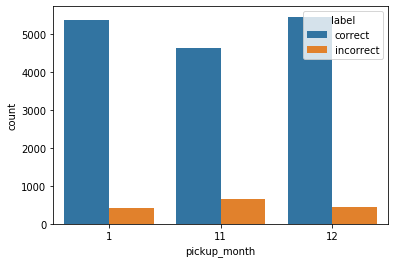

In [28]:
sns.countplot(x='pickup_month', data=data, hue='label')

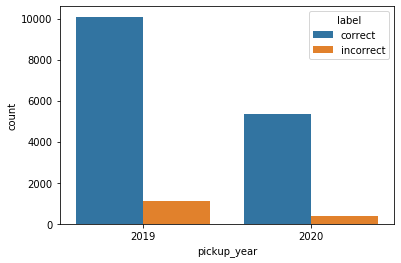

In [29]:
sns.countplot(x='pickup_year', data=data, hue='label')

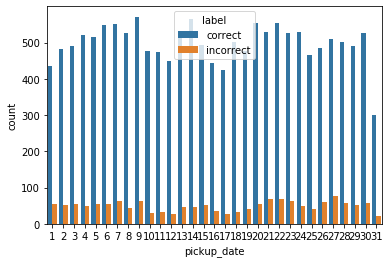

In [30]:
sns.countplot(x='pickup_date', data=data, hue='label')

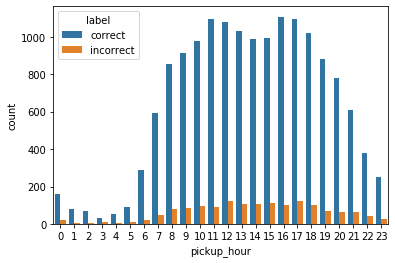

In [31]:
sns.countplot(x='pickup_hour', data=data, hue='label')

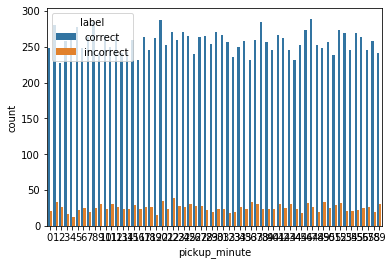

In [32]:
sns.countplot(x='pickup_minute', data=data, hue='label')

In [33]:
data[data['label']=='correct'].describe()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,...,pickup_month,pickup_date,pickup_year,pickup_hour,pickup_minute,drop_month,drop_date,drop_year,drop_hour,drop_minute
count,15441.000000,15441.000000,15441.000000,15441.000000,15441.000000,15441.000000,15441.000000,15441.000000,15441.00000,15441.000000,...,15441.000000,15441.000000,15441.000000,15441.000000,15441.000000,15441.000000,15441.000000,15441.000000,15441.000000,15441.000000
mean,12.444466,1414.038534,356.675539,16.910844,107.549770,6.963291,79.995067,6.964221,79.99592,277.625584,...,7.883233,15.829933,2019.346998,13.797358,29.459880,7.881808,15.830646,2019.347128,14.077650,29.410595
std,10.913710,4186.139145,3998.101982,231.330692,446.800734,0.210664,0.239488,0.211222,0.23971,341.301572,...,5.033929,8.811311,0.476031,4.824611,17.302852,5.034321,8.810866,0.476072,4.881576,17.376185
min,0.000000,22.000000,0.000000,0.000000,0.000000,5.937600,79.819100,5.941860,79.79670,0.000000,...,1.000000,1.000000,2019.000000,0.000000,0.000000,1.000000,1.000000,2019.000000,0.000000,0.000000
25%,10.500000,552.000000,33.000000,0.000000,25.000000,6.864060,79.870400,6.865520,79.86980,125.060000,...,1.000000,8.000000,2019.000000,10.000000,15.000000,1.000000,8.000000,2019.000000,11.000000,14.000000
50%,10.500000,1003.000000,122.000000,0.290571,71.000000,6.912960,79.898400,6.915330,79.89830,204.720000,...,11.000000,16.000000,2019.000000,14.000000,29.000000,11.000000,16.000000,2019.000000,14.000000,29.000000
75%,10.500000,1753.000000,340.000000,14.093501,141.000000,7.037840,79.954900,7.042610,79.95760,341.580000,...,12.000000,23.000000,2020.000000,18.000000,45.000000,12.000000,23.000000,2020.000000,18.000000,44.000000
max,221.000000,453872.000000,453650.000000,26198.601400,51288.000000,8.051010,81.009600,8.064930,81.00970,26945.990000,...,12.000000,31.000000,2020.000000,23.000000,59.000000,12.000000,31.000000,2020.000000,23.000000,59.000000


In [34]:
data[data['label']=='incorrect'].describe()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,...,pickup_month,pickup_date,pickup_year,pickup_hour,pickup_minute,drop_month,drop_date,drop_year,drop_hour,drop_minute
count,1526.000000,1526.000000,1526.000000,1526.000000,1526.000000,1526.000000,1526.000000,1526.000000,1526.000000,1526.000000,...,1526.000000,1526.000000,1526.000000,1526.000000,1526.000000,1526.000000,1526.000000,1526.000000,1526.000000,1526.000000
mean,26.644725,4625.986894,3383.534731,185.202069,162.482307,6.983739,80.027471,6.982349,80.031867,667.299417,...,8.623853,16.157929,2019.267366,13.860419,29.747051,8.625164,16.161206,2019.267366,14.129096,29.410878
std,328.083613,23388.967206,23525.113193,1357.918087,388.522509,0.211459,0.272331,0.213387,0.271794,1665.277732,...,4.626233,9.165328,0.442730,4.768563,17.133006,4.627048,9.170671,0.442730,4.884473,17.445886
min,0.000000,0.000000,0.000000,0.000000,0.000000,5.955910,79.838500,5.998940,79.819900,0.000000,...,1.000000,1.000000,2019.000000,0.000000,0.000000,1.000000,1.000000,2019.000000,0.000000,0.000000
25%,10.500000,472.000000,30.000000,0.000000,40.000000,6.871298,79.870800,6.867005,79.873750,135.757500,...,1.000000,8.000000,2019.000000,10.000000,15.000000,1.000000,7.250000,2019.000000,11.000000,14.000000
50%,10.500000,1105.500000,146.500000,0.000000,94.500000,6.919950,79.900500,6.920890,79.905600,388.470000,...,11.000000,17.000000,2019.000000,14.000000,29.000000,11.000000,17.000000,2019.000000,14.000000,29.000000
75%,10.500000,2514.250000,581.250000,16.993200,181.750000,7.082043,79.974450,7.084218,79.985025,652.855000,...,12.000000,24.000000,2020.000000,17.000000,44.750000,12.000000,24.000000,2020.000000,18.000000,45.000000
max,12795.030000,442190.000000,435308.000000,25098.436200,11722.000000,7.500680,80.722500,7.531470,80.751100,26098.750000,...,12.000000,31.000000,2020.000000,23.000000,59.000000,12.000000,31.000000,2020.000000,23.000000,59.000000


In [35]:
train_df.shape

(17176, 24)

In [36]:
train_df['pickup_time'].value_counts()['12/6/2019 11:31']

4

In [37]:
train_df[train_df['pickup_time'] == '12/6/2019 11:31']

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,...,pickup_month,pickup_date,pickup_year,pickup_hour,pickup_minute,drop_month,drop_date,drop_year,drop_hour,drop_minute
6459,198352508,10.5,2296.0,430.0,24.8540,9.0,12/6/2019 11:31,12/6/2019 12:09,6.87557,79.8644,...,12,6,2019,11,31,12,6,2019,12,9
6460,198351976,60.5,873.0,190.0,11.0770,154.0,12/6/2019 11:31,12/6/2019 11:45,6.85789,79.8614,...,12,6,2019,11,31,12,6,2019,11,45
6461,198351064,10.5,4270.0,1084.0,62.6552,73.0,12/6/2019 11:31,12/6/2019 12:42,6.97717,79.8931,...,12,6,2019,11,31,12,6,2019,12,42
6462,198353025,10.5,184.0,0.0,0.0000,32.0,12/6/2019 11:31,12/6/2019 11:34,6.91473,79.9721,...,12,6,2019,11,31,12,6,2019,11,34


In [38]:
pickup_time_counts = train_df['pickup_time'].value_counts()

In [39]:
train_df['pickup_time_count'] = train_df['pickup_time'].apply(lambda x: pickup_time_counts[x])

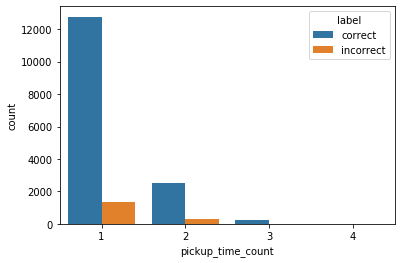

In [40]:
sns.countplot(x='pickup_time_count', data=train_df, hue='label')

In [41]:
train_df[train_df['label'] == 'incorrect'].shape

(1681, 25)

In [42]:
train_df[train_df['label'] == 'incorrect'].shape[0] / train_df.shape[0]

0.09786911970190965

In [43]:
data[data['label'] == 'incorrect'].shape[0] / data.shape[0]

0.08993929392349856

In [44]:
train_df[train_df['pickup_year'] == 2020]['pickup_month'].unique()

array([1])

In [45]:
test_df[test_df['pickup_year'] == 2020]['pickup_month'].unique()

array([2, 3])

In [46]:
tmp = train_df.copy()

In [47]:
tmp['label'] = 1

In [48]:
tmp_1 ,tmp_2 = train_test_split(tmp,test_size=0.1,random_state=42)

In [49]:
tmp_2['label'] = 0

/home/heshan/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [50]:
tmp_new = tmp_1.append(tmp_2)

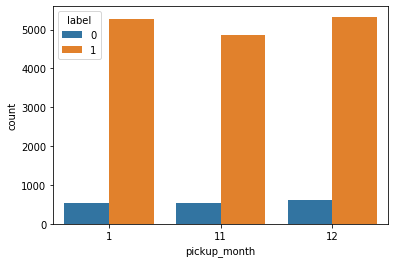

In [51]:
sns.countplot(x='pickup_month', data=tmp_new, hue='label')

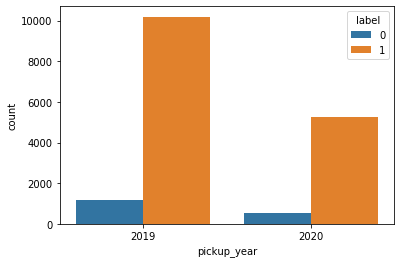

In [52]:
sns.countplot(x='pickup_year', data=tmp_new, hue='label')

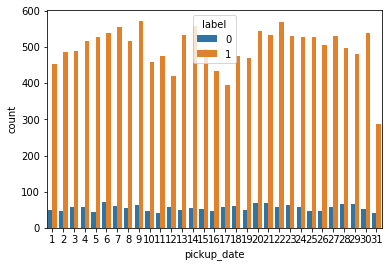

In [53]:
sns.countplot(x='pickup_date', data=tmp_new, hue='label')

In [54]:
def encode_label(label):
    if label == 'correct':
        return 1
    elif label == 'incorrect':
        return 0
    else:
        return label

In [55]:
train_df['label'] = train_df['label'].map(encode_label)

In [56]:
def random_split(seed=0,test_size=0.1):
    tmp = train_df.copy()
    tmp['label'] = 1
    tmp_1 ,tmp_2 = train_test_split(tmp,test_size=test_size,random_state=seed)
    tmp_2['label'] = 0
    tmp_new = tmp_1.append(tmp_2)
#     tmp_new.sort_values(by='tripid', inplace=True)
#     return f1_score(train_df['label'], tmp_new['label'], average='macro')
    return tmp_new

In [64]:
def f(params):
    seed = int(params['seed'])
    test_size = params['test_size']
    tmp_new = random_split(seed, test_size)
    tmp_new.sort_values(by='tripid', inplace=True)
    value = f1_score(train_df['label'], tmp_new['label'], average='macro')
    return value * -1

In [65]:
space = {
    'seed': hp.quniform('seed', 0, 1_000, 1),
    'test_size': hp.uniform('test_size', 0.08, 0.1),
}

In [66]:
fmin(fn=f,space=space,algo=tpe.suggest,max_evals=100_000,verbose= 1)

  0%|          | 3/100000 [00:00<57:14, 29.12trial/s, best loss: -0.5043396163700905]

/home/heshan/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """



 22%|██▏       | 21827/100000 [3:00:10<10:45:18,  2.02trial/s, best loss: -0.5127470267867915]


KeyboardInterrupt: 

In [1]:
values = []
for i in tqdm(range(1_000_000)):
    tmp_new = random_split(i)
    tmp_new.sort_values(by='tripid', inplace=True)
    value = f1_score(train_df['label'], tmp_new['label'], average='macro')
    values.append(value)
    

NameError: name 'tqdm' is not defined

In [60]:
1-(train_df.label.sum()/ train_df.shape[0])

0.09786911970190959

In [62]:
values = []
test_sizes = [0.1,0.09,0.099,0.098,0.097,0.095]
best_score = 0
best_conf = {}
for test_size in tqdm(test_sizes):
    for seed in range(1_000):
        tmp_new = random_split(seed, test_size)
        tmp_new.sort_values(by='tripid', inplace=True)
        value = f1_score(train_df['label'], tmp_new['label'], average='macro')
        if value > best_score:
            best_score = value
            best_conf['test_size'] = test_size
            best_conf['seed'] = seed
        values.append(value)




  0%|          | 0/6 [00:00<?, ?it/s]/home/heshan/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


 17%|█▋        | 1/6 [00:21<01:46, 21.34s/it]

 33%|███▎      | 2/6 [00:42<01:25, 21.29s/it]

 50%|█████     | 3/6 [01:04<01:04, 21.56s/it]

 67%|██████▋   | 4/6 [01:27<00:43, 21.98s/it]

 83%|████████▎ | 5/6 [01:51<00:22, 22.39s/it]

100%|██████████| 6/6 [02:13<00:00, 22.22s/it]


In [63]:
best_score

0.5128012614449119

In [9]:
np.std(values)

0.003816117928704071

In [10]:
np.argmax(values)

878523